In [3]:
import numpy as np
import cv2
import os
import pandas as pd
import tensorflow as tf
import random
import copy
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from google.colab import drive
import matplotlib.pyplot as plt


drive.mount('/content/drive/')

## Folder path for the UTK image dataset

folder_path = '/content/drive/MyDrive/UTKFace/'

## Paths for the npy files created for ease

images_path = '/content/drive/MyDrive/FaceFiles/images_full.npy'

ages_path = '/content/drive/MyDrive/FaceFiles/ages_full.npy'

genders_path = '/content/drive/MyDrive/FaceFiles/genders_full.npy'

races_path = '/content/drive/MyDrive/FaceFiles/races_full.npy'

def load_images_from_folder(folder):
    images = []
    ages = []
    genders = []
    races = []
    dates = []
    for filename in os.listdir(folder):
        print(filename)
        img = cv2.imread(os.path.join(folder,filename))
        if img is not None:
          if (len(filename.split('_')) == 4):
            age, gender, race, date = filename_data(filename)
            images.append(img)
            ages.append(age)
            genders.append(gender)
            races.append(race)
            dates.append(date)
    return images, ages, genders, races, dates


def filename_data(filename):
  img_name = filename
  data = img_name.split('_')
  age = data[0]
  gender = data[1]
  race = data[2]
  data2 = data[3]
  date = data2.split('.')[0]
  return age, gender, race, date
def get_accuracy(predicted, actual):
  n = len(predicted)
  tot = 0
  for i in range(n):
    if predicted[i] == actual[i]:
      tot = tot + 1
  return tot/n

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


# Saving and Loading

In [2]:
## This is just to save the data for later so loading isn't required every time
## Don't run if you already have the data in the .npy files
images, ages, genders, races, dates = load_images_from_folder(folder_path)
np.save('images.npy', images)
np.save('ages.npy', ages)
np.save('genders.npy', genders)
np.save('races.npy', races)
np.save('dates.npy', dates)

FileNotFoundError: ignored

In [81]:
## Loading
images = np.load(images_path)
ages = np.load(ages_path)
genders = np.load(genders_path)
races = np.load(races_path)
#dates = np.load(dates_path)

# Data Manipulation

In [19]:
## gender: 0=male, 1=female
## race: 0=white, 1=black, 2=asian, 3=indian
## n = 23705
## Balance models n = 10824, all = 2706
## Gender_full n = 18964, w = 8091, b = 3652, a = 2706, i = 3172, o = 1343
## Race_full n = 17621, w = 8091, b = 3652, a = 2706, i = 3172
genders = genders.astype(np.uint8)
races = races.astype(np.uint8)

random.seed(1)
trn_idx = random.sample(range(23705), round(23705*.8))

trn_bool = [False] * 23705

for i in trn_idx:
  trn_bool[i] = True

tst_bool = np.invert(trn_bool)

races_trn = races[trn_bool]
races_tst = races[tst_bool]
img_trn = images[trn_bool]
img_tst = images[tst_bool]
gender_trn = genders[trn_bool]
gender_tst = genders[tst_bool]

del images

white = races == 0
black = races == 1
asian = races == 2
indian = races == 3
other = races == 4

four_race_trn = races_trn != 4

n_male = sum(genders == 0)
n_female = sum(genders == 1)

n_white = len(genders[white])
n_black = len(genders[black])
n_asian = len(genders[asian])
n_indian = len(genders[indian])
n_other = len(genders[other])
n_tot = len(genders)

white_genders = genders[white]
black_genders = genders[black]
asian_genders = genders[asian]
indian_genders = genders[indian]
other_genders = genders[other]


white_trn = races_trn == 0
black_trn = races_trn == 1
asian_trn = races_trn == 2
indian_trn = races_trn == 3
n_w_trn = sum(white_trn)
n_b_trn = sum(black_trn)
n_a_trn = sum(asian_trn)
n_i_trn = sum(indian_trn)
min_n = min(n_w_trn, n_b_trn, n_a_trn, n_i_trn)


white_img_trn = img_trn[white_trn]
white_gender_trn = gender_trn[white_trn]
white_race_trn = races_trn[white_trn]
random.seed(101)
whiteTrnIdx2 = random.sample(range(n_w_trn), min_n)
whiteImgTrn2 = white_img_trn[whiteTrnIdx2]
whiteGenderTrn2 = white_gender_trn[whiteTrnIdx2]
whiteRaceTrn2 = white_race_trn[whiteTrnIdx2]


black_img_trn = img_trn[black_trn]
black_gender_trn = gender_trn[black_trn]
black_race_trn = races_trn[black_trn]
random.seed(102)
blackTrnIdx2 = random.sample(range(n_b_trn), min_n)
blackImgTrn2 = black_img_trn[blackTrnIdx2]
blackGenderTrn2 = black_gender_trn[blackTrnIdx2]
blackRaceTrn2 = black_race_trn[blackTrnIdx2]


asian_img_trn = img_trn[asian_trn]
asian_gender_trn = gender_trn[asian_trn]
asian_race_trn = races_trn[asian_trn]
random.seed(103)
asianTrnIdx2 = random.sample(range(n_a_trn), min_n)
asianImgTrn2 = black_img_trn[asianTrnIdx2]
asianGenderTrn2 = asian_gender_trn[asianTrnIdx2]
asianRaceTrn2 = asian_race_trn[asianTrnIdx2]


indian_img_trn = img_trn[indian_trn]
indian_gender_trn = gender_trn[indian_trn]
indian_race_trn = races_trn[indian_trn]
random.seed(104)
indianTrnIdx2 = random.sample(range(n_i_trn), min_n)
indianImgTrn2 = indian_img_trn[indianTrnIdx2]
indianGenderTrn2 = indian_gender_trn[indianTrnIdx2]
indianRaceTrn2 = indian_race_trn[indianTrnIdx2]


imgTrnBalance = np.concatenate((whiteImgTrn2, blackImgTrn2, asianImgTrn2, indianImgTrn2))
genderTrnBalance = np.concatenate((whiteGenderTrn2, blackGenderTrn2, asianGenderTrn2, indianGenderTrn2))
raceTrnBalance = np.concatenate((whiteRaceTrn2, blackRaceTrn2, asianRaceTrn2, indianRaceTrn2))
del whiteImgTrn2
del blackImgTrn2
del asianImgTrn2
del indianImgTrn2
del white_img_trn
del black_img_trn
del asian_img_trn
del indian_img_trn

# Graphs for Data

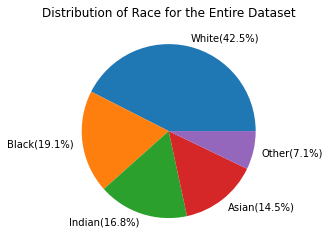

In [6]:
## racial distribution
import matplotlib.pyplot as plt
race_pie  = np.array([n_white, n_black, n_indian, n_asian, n_other])
label = ['White(42.5%)', 'Black(19.1%)', 'Indian(16.8%)', 'Asian(14.5%)', 'Other(7.1%)']
plt.title('Distribution of Race for the Entire Dataset')
plt.pie(race_pie, labels = label)
plt.show()

([<matplotlib.patches.Wedge at 0x7fb2ed4c2f10>,
 [Text(-0.07843666139757915, 1.097199931711993, 'Male(52.3%)'),
  Text(0.07843655867030727, -1.0971999390557583, 'Female(47.7%)')])

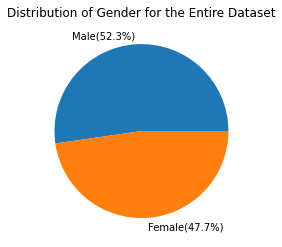

In [7]:
## gender distribution
gender_pie = np.array([n_male, n_female])
plt.title('Distribution of Gender for the Entire Dataset')
plt.pie(gender_pie, labels = ['Male(52.3%)', 'Female(47.7%)'])

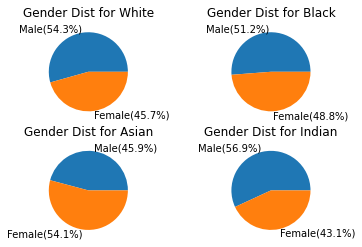

In [8]:
## 4 race gender dist plots
fig, axes = plt.subplots(2,2)

w_m = sum(white_genders == 0)
w_f = sum(white_genders == 1)
m_per = round(100*w_m/n_white,1)
f_per = round(100*w_f/n_white,1)
gender_pie = np.array([w_m, w_f])
axes[0,0].set_title('Gender Dist for White')
axes[0,0].pie(gender_pie, labels = [f'Male({m_per}%)', f'Female({f_per}%)'])


b_m = sum(black_genders == 0)
b_f = sum(black_genders == 1)
m_per = round(100*b_m/n_black,1)
f_per = round(100*b_f/n_black,1)
gender_pie = np.array([b_m, b_f])
axes[0,1].set_title('Gender Dist for Black')
axes[0,1].pie(gender_pie, labels = [f'Male({m_per}%)', f'Female({f_per}%)'])


a_m = sum(asian_genders == 0)
a_f = sum(asian_genders == 1)
m_per = round(100*a_m/n_asian,1)
f_per = round(100*a_f/n_asian,1)
gender_pie = np.array([a_m, a_f])
axes[1,0].set_title('Gender Dist for Asian')
axes[1,0].pie(gender_pie, labels = [f'Male({m_per}%)', f'Female({f_per}%)'])


i_m = sum(indian_genders == 0)
i_f = sum(indian_genders == 1)
m_per = round(100*i_m/n_indian,1)
f_per = round(100*i_f/n_indian,1)
gender_pie = np.array([i_m, i_f])
axes[1,1].set_title('Gender Dist for Indian')
axes[1,1].pie(gender_pie, labels = [f'Male({m_per}%)', f'Female({f_per}%)'])


plt.show()

# MODEL

In [ ]:
## This is the model for gender classification
def createGenderModel():
  model = tf.keras.models.Sequential()

  model.add(
    layers.Conv2D(64, (5,5),
                  activation = 'relu',
                  input_shape = (200,200,3))
  )
  model.add(
      layers.SpatialDropout2D(.5)
  )
  model.add(
    layers.MaxPooling2D((2,2))
  )
  model.add(
    layers.Conv2D(128, (3,3),
                  activation = 'relu')
  )
  model.add(
      layers.SpatialDropout2D(.5)
  )
  model.add(
    layers.MaxPooling2D((2,2))
  )
  model.add(
    layers.Flatten()
  )
  model.add(
    layers.Dense(128, activation = 'relu')
  )
  model.add(
      layers.Dense(128, activation = 'relu')
  )
  ## Sigmoid for binary classification
  model.add(
    layers.Dense(1, activation = 'sigmoid')
  )
  ## Might need to change learning rate later
  model.compile(
  optimizer = optimizers.SGD(learning_rate=1e-4),
  loss = 'binary_crossentropy',
  metrics = ['accuracy']
  )
  return model



## This is the model for race classification
def createRaceModel():
  model = tf.keras.models.Sequential()

  model.add(
    layers.Conv2D(64, (5,5),
                  activation = 'relu',
                  input_shape = (200,200,3))
  )
  model.add(
      layers.SpatialDropout2D(.5)
  )
  model.add(
    layers.MaxPooling2D((2,2))
  )
  model.add(
    layers.Conv2D(128, (3,3),
                  activation = 'relu')
  )
  model.add(
      layers.SpatialDropout2D(.5)
  )
  model.add(
    layers.MaxPooling2D((2,2))
  )
  model.add(
    layers.Flatten()
  )
  model.add(
    layers.Dense(128, activation = 'relu')
  )
  model.add(
      layers.Dense(128, activation = 'relu')
  )
  ## softmax for catagorical classification(might need to change to 4 and not include other as gender)
  model.add(
    layers.Dense(5, activation = 'softmax')
  )
  ## Might need to change learning rate later
  model.compile(
  optimizer = optimizers.SGD(learning_rate=1e-4),
  loss = 'catagorical_crossentropy',
  metrics = ['accuracy']
  )
  return model

# Model Training and diagnostics

In [80]:
len(images)

NameError: ignored

In [ ]:
gender_model = createGenderModel()
gender_model_balance = createGenderModel()

In [ ]:
gender_model_history = gender_model.fit(img_trn, gender_trn, epochs = 50)
gender_model_balance_history = gender_model_balance.fit(imgTrnBalance, genderTrnBalance, epochs = 50)


Epoch 1/50
593/593 [==============================] - 59s 48ms/step - loss: 3.2284 - accuracy: 0.5682
Epoch 2/50
593/593 [==============================] - 28s 47ms/step - loss: 0.5769 - accuracy: 0.7086
Epoch 3/50
593/593 [==============================] - 28s 47ms/step - loss: 0.4950 - accuracy: 0.7728
Epoch 4/50
593/593 [==============================] - 28s 47ms/step - loss: 0.4463 - accuracy: 0.7998
Epoch 5/50
593/593 [==============================] - 28s 47ms/step - loss: 0.4209 - accuracy: 0.8112
Epoch 6/50
593/593 [==============================] - 28s 47ms/step - loss: 0.3952 - accuracy: 0.8250
Epoch 7/50
593/593 [==============================] - 28s 47ms/step - loss: 0.3771 - accuracy: 0.8374
Epoch 8/50
593/593 [==============================] - 28s 47ms/step - loss: 0.3681 - accuracy: 0.8356
Epoch 9/50
593/593 [==============================] - 28s 47ms/step - loss: 0.3566 - accuracy: 0.8449
Epoch 10/50
593/593 [==============================] - 28s 47ms/step - loss: 0.336

In [ ]:
w_p_w = (white_model.predict(white_images_2) > 0.5).astype("int32")
w_p_b = (white_model.predict(black_images) > 0.5).astype("int32")
w_p_a = (white_model.predict(asian_images_2) > 0.5).astype("int32")
w_p_i = (white_model.predict(indian_images_2) > 0.5).astype("int32")

w = get_accuracy(w_p_w, white_genders_2)
b = get_accuracy(w_p_b, black_genders)
a = get_accuracy(w_p_a, asian_genders_2)
i = get_accuracy(w_p_i, indian_genders_2)
fig = plt.figure()
labs = ['white', 'black', 'asian', 'indian']
accuracies = [w,b,a,i]
plt.bar(labs,accuracies)
plt.ylabel('accuracies')
plt.title('Prediction Accuracies of Model trained only on white faces')
plt.show()

NameError: ignored

In [ ]:
b_p_w = (black_model.predict(white_images_2) > 0.5).astype("int32")
b_p_b = (black_model.predict(black_images) > 0.5).astype("int32")
b_p_a = (black_model.predict(asian_images_2) > 0.5).astype("int32")
b_p_i = (black_model.predict(indian_images_2) > 0.5).astype("int32")

w = get_accuracy(b_p_w, white_genders_2)
b = get_accuracy(b_p_b, black_genders)
a = get_accuracy(b_p_a, asian_genders_2)
i = get_accuracy(b_p_i, indian_genders_2)
fig = plt.figure()
labs = ['white', 'black', 'asian', 'indian']
accuracies = [w,b,a,i]
plt.bar(labs,accuracies)
plt.ylabel('accuracies')
plt.title('Prediction Accuracies of Model trained only on Black faces')
plt.show()

In [ ]:
a_p_w = (asian_model.predict(white_images_2) > 0.5).astype("int32")
a_p_b = (asian_model.predict(black_images) > 0.5).astype("int32")
a_p_a = (asian_model.predict(asian_images_2) > 0.5).astype("int32")
a_p_i = (asian_model.predict(indian_images_2) > 0.5).astype("int32")

w = get_accuracy(a_p_w, white_genders_2)
b = get_accuracy(a_p_b, black_genders)
a = get_accuracy(a_p_a, asian_genders_2)
i = get_accuracy(a_p_i, indian_genders_2)
fig = plt.figure()
labs = ['white', 'black', 'asian', 'indian']
accuracies = [w,b,a,i]
plt.bar(labs,accuracies)
plt.ylabel('accuracies')
plt.title('Prediction Accuracies of Model trained only on Asian faces')
plt.show()

In [82]:
len(images)

23705

In [ ]:
i_p_w = (indian_model.predict(white_images_2) > 0.5).astype("int32")
i_p_b = (indian_model.predict(black_images) > 0.5).astype("int32")
i_p_a = (indian_model.predict(asian_images_2) > 0.5).astype("int32")
i_p_i = (indian_model.predict(indian_images_2) > 0.5).astype("int32")

w = get_accuracy(i_p_w, white_genders_2)
b = get_accuracy(i_p_b, black_genders)
a = get_accuracy(i_p_a, asian_genders_2)
i = get_accuracy(i_p_i, indian_genders_2)
fig = plt.figure()
labs = ['white', 'black', 'asian', 'indian']
accuracies = [w,b,a,i]
plt.bar(labs,accuracies)
plt.ylabel('accuracies')
plt.title('Prediction Accuracies of Model trained only on Indian faces')
plt.show()

In [ ]:
def createModel2():
  model2 = tf.keras.models.Sequential()

  model2.add(
    layers.Conv2D(128, (8,8),
                  activation = 'relu',
                  input_shape = (200,200,3))
  )
  model2.add(
    layers.MaxPooling2D((2,2))
  )
  model2.add(
    layers.Conv2D(64, (4,4),
                  activation = 'relu')
  )
  model2.add(
    layers.MaxPooling2D((2,2))
  )
  model2.add(
    layers.Conv2D(32, (2,2),
                  activation = 'relu')
  )
  model2.add(
    layers.MaxPooling2D((2,2))
  )
  model2.add(
    layers.Flatten()
  )
  model2.add(
    layers.Dense(128, activation = 'relu')
  )
  model2.add(
      layers.Dropout(.2)
  )
  model2.add(
    layers.Dense(64, activation = 'relu')
  )
  model2.add(
      layers.Dropout(.2)
  )
  model2.add(
      layers.Dense(10, activation = 'relu')
  )
  model2.add(
      layers.Dropout(.2)
  )
## Sigmoid for binary classification
  model2.add(
    layers.Dense(1, activation = 'sigmoid')
  )
## Might need to change learning rate later
  model2.compile(
  optimizer = optimizers.SGD(learning_rate=1e-9),
  loss = 'binary_crossentropy',
  metrics = ['accuracy']
  )
  return model2

In [ ]:
gender_model2 = createGenderModel()
gender_model_balance2 = createGenderModel()

In [ ]:
gender_model_2 = createModel2()

In [ ]:
## This is the model for gender classification
def createGenderModel2():
  model = tf.keras.models.Sequential()

  model.add(
    layers.Conv2D(32, (5,5),
                  activation = 'relu',
                  input_shape = (200,200,3))
  )
  model.add(
    layers.SpatialDropout2D(.5)
  )
  model.add(
    layers.MaxPooling2D((2,2))
  )
    
  model.add(
    layers.Conv2D(64, (5,5),
                  activation = 'relu')
  )
  model.add(
      layers.SpatialDropout2D(.5)
  )
  model.add(
    layers.MaxPooling2D((2,2))
  )
  model.add(
    layers.Conv2D(128, (3,3),
                  activation = 'relu')
  )
  model.add(
      layers.SpatialDropout2D(.5)
  )
  model.add(
    layers.MaxPooling2D((2,2))
  )
  model.add(
    layers.Flatten()
  )
  model.add(
    layers.Dense(128, activation = 'relu')
  )
  model.add(
      layers.Dense(128, activation = 'relu')
  )
  ## Sigmoid for binary classification
  model.add(
    layers.Dense(1, activation = 'sigmoid')
  )
  ## Might need to change learning rate later
  model.compile(
  optimizer = optimizers.SGD(learning_rate=1e-5),
  loss = 'binary_crossentropy',
  metrics = ['accuracy']
  )
  return model



## This is the model for race classification
def createRaceModel2():
  model = tf.keras.models.Sequential()

  model.add(
    layers.Conv2D(32, (5,5),
                  activation = 'relu',
                  input_shape = (200,200,3))
  )
  model.add(
    layers.SpatialDropout2D(.5)
  )
  model.add(
    layers.MaxPooling2D((2,2))
  )

  model.add(
    layers.Conv2D(64, (5,5),
                  activation = 'relu')
  )
  model.add(
      layers.SpatialDropout2D(.5)
  )
  model.add(
    layers.MaxPooling2D((2,2))
  )

  model.add(
    layers.Conv2D(128, (3,3),
                  activation = 'relu')
  )
  model.add(
      layers.SpatialDropout2D(.5)
  )
  model.add(
    layers.MaxPooling2D((2,2))
  )
  model.add(
    layers.Flatten()
  )
  model.add(
    layers.Dense(128, activation = 'relu')
  )
  model.add(
      layers.Dense(128, activation = 'relu')
  )
  ## softmax for catagorical classification(might need to change to 4 and not include other as gender)
  model.add(
    layers.Dense(5, activation = 'softmax')
  )
  ## Might need to change learning rate later
  model.compile(
  optimizer = optimizers.SGD(learning_rate=1e-5),
  loss = 'catagorical_crossentropy',
  metrics = ['accuracy']
  )
  return model

In [ ]:
gender_model2 = createGenderModel2()
gender_model_balance2 = createGenderModel2()

In [ ]:
gender_model_history_2 = gender_model2.fit(img_trn, gender_trn, epochs = 50)
gender_model_balance_history_2 = gender_model_balance2.fit(imgTrnBalance, genderTrnBalance, epochs = 50)

Epoch 1/50
593/593 [==============================] - 51s 84ms/step - loss: 3.0696 - accuracy: 0.5149
Epoch 2/50
593/593 [==============================] - 49s 83ms/step - loss: 0.9809 - accuracy: 0.5414
Epoch 3/50
593/593 [==============================] - 49s 82ms/step - loss: 0.7874 - accuracy: 0.5671
Epoch 4/50
593/593 [==============================] - 49s 83ms/step - loss: 0.7276 - accuracy: 0.5853
Epoch 5/50
593/593 [==============================] - 49s 83ms/step - loss: 0.7018 - accuracy: 0.6018
Epoch 6/50
593/593 [==============================] - 49s 83ms/step - loss: 0.6873 - accuracy: 0.6131
Epoch 7/50
593/593 [==============================] - 49s 83ms/step - loss: 0.6726 - accuracy: 0.6266
Epoch 8/50
593/593 [==============================] - 49s 82ms/step - loss: 0.6607 - accuracy: 0.6391
Epoch 9/50
593/593 [==============================] - 49s 82ms/step - loss: 0.6466 - accuracy: 0.6572
Epoch 10/50
593/593 [==============================] - 49s 82ms/step - loss: 0.641

KeyboardInterrupt: ignored

In [ ]:

gender_2 = gender_model_2.fit(img_trn, gender_trn, epochs = 50)


Epoch 1/50
593/593 [==============================] - 120s 147ms/step - loss: 8.9623 - accuracy: 0.4891
Epoch 2/50
593/593 [==============================] - 87s 147ms/step - loss: 8.6543 - accuracy: 0.4977
Epoch 3/50
593/593 [==============================] - 87s 147ms/step - loss: 8.9037 - accuracy: 0.4926
Epoch 4/50
593/593 [==============================] - 88s 148ms/step - loss: 8.4436 - accuracy: 0.4908
Epoch 5/50
593/593 [==============================] - 88s 148ms/step - loss: 8.4224 - accuracy: 0.5016
Epoch 6/50
593/593 [==============================] - 88s 148ms/step - loss: 8.3425 - accuracy: 0.4911
Epoch 7/50
 20/593 [>.............................] - ETA: 1:24 - loss: 8.8870 - accuracy: 0.4731

KeyboardInterrupt: ignored

In [ ]:
## This is the model for gender classification
def createGenderModel3():
  model = tf.keras.models.Sequential()

  model.add(
    layers.Conv2D(64, (5,5),
                  activation = 'relu',
                  input_shape = (200,200,3))
  )
  model.add(
      layers.SpatialDropout2D(.5)
  )
  model.add(
    layers.MaxPooling2D((2,2))
  )
  model.add(
    layers.Conv2D(64, (5,5), activation = 'relu')
  )
  model.add(
      layers.SpatialDropout2D(.5)
  )
  model.add(
    layers.MaxPooling2D((2,2))
  )
  model.add(
    layers.Conv2D(128, (3,3), activation = 'relu')
  )
  model.add(
      layers.SpatialDropout2D(.5)
  )
  model.add(
    layers.MaxPooling2D((2,2))
  )
  model.add(
    layers.Flatten()
  )
  model.add(
    layers.Dense(128, activation = 'relu')
  )
  model.add(
      layers.Dense(128, activation = 'relu')
  )
  ## Sigmoid for binary classification
  model.add(
    layers.Dense(1, activation = 'sigmoid')
  )
  ## Might need to change learning rate later
  model.compile(
  optimizer = optimizers.SGD(learning_rate=1e-4),
  loss = 'binary_crossentropy',
  metrics = ['accuracy']
  )
  return model



## This is the model for race classification
def createRaceModel3():
  model = tf.keras.models.Sequential()

  model.add(
    layers.Conv2D(64, (5,5),
                  activation = 'relu',
                  input_shape = (200,200,3))
  )
  model.add(
      layers.SpatialDropout2D(.5)
  )
  model.add(
    layers.MaxPooling2D((2,2))
  )
  model.add(
    layers.Conv2D(64, (5,5),
                  activation = 'relu')
  )
  model.add(
      layers.SpatialDropout2D(.5)
  )
  model.add(
    layers.MaxPooling2D((2,2))
  )

  model.add(
    layers.Conv2D(128, (3,3),
                  activation = 'relu')
  )
  model.add(
      layers.SpatialDropout2D(.5)
  )
  model.add(
    layers.MaxPooling2D((2,2))
  )
  model.add(
    layers.Flatten()
  )
  model.add(
    layers.Dense(128, activation = 'relu')
  )
  model.add(
      layers.Dense(128, activation = 'relu')
  )
  ## softmax for catagorical classification(might need to change to 4 and not include other as gender)
  model.add(
    layers.Dense(5, activation = 'softmax')
  )
  ## Might need to change learning rate later
  model.compile(
  optimizer = optimizers.SGD(learning_rate=1e-4),
  loss = 'catagorical_crossentropy',
  metrics = ['accuracy']
  )
  return model

In [ ]:
gender_model3 = createGenderModel3()
gender_model_balance3 = createGenderModel3()

In [ ]:
gender_model_history_3 = gender_model3.fit(img_trn, gender_trn, epochs = 50)
gender_model_balance_history_3 = gender_model_balance3.fit(imgTrnBalance, genderTrnBalance, epochs = 50)

Epoch 1/50
593/593 [==============================] - 77s 127ms/step - loss: 2.4193 - accuracy: 0.5387
Epoch 2/50
593/593 [==============================] - 75s 126ms/step - loss: 0.6887 - accuracy: 0.5877
Epoch 3/50
593/593 [==============================] - 75s 126ms/step - loss: 0.6569 - accuracy: 0.6252
Epoch 4/50
593/593 [==============================] - 75s 126ms/step - loss: 0.6332 - accuracy: 0.6503
Epoch 5/50
593/593 [==============================] - 75s 126ms/step - loss: 0.6107 - accuracy: 0.6776
Epoch 6/50
593/593 [==============================] - 75s 126ms/step - loss: 0.5882 - accuracy: 0.6951
Epoch 7/50
593/593 [==============================] - 75s 126ms/step - loss: 0.5629 - accuracy: 0.7191
Epoch 8/50
593/593 [==============================] - 75s 126ms/step - loss: 0.5501 - accuracy: 0.7304
Epoch 9/50
593/593 [==============================] - 75s 126ms/step - loss: 0.5382 - accuracy: 0.7419
Epoch 10/50
593/593 [==============================] - 75s 126ms/step - l

KeyboardInterrupt: ignored

In [11]:
from tensorflow.python.keras import regularizers

In [28]:
## This is the model for gender classification
def createGenderModel4():
  model = tf.keras.models.Sequential()

  model.add(
    layers.Conv2D(64, (5,5),
                  activation = 'relu',
                  input_shape = (200,200,3))
  )
  model.add(
      layers.SpatialDropout2D(.5)
  )
  model.add(
    layers.MaxPooling2D((2,2))
  )
  model.add(
    layers.Conv2D(128, (3,3),
                  activation = 'relu', kernel_regularizer = regularizers.l2(l=0.01))
  )
  model.add(
      layers.SpatialDropout2D(.5)
  )
  model.add(
    layers.MaxPooling2D((2,2))
  )
  model.add(
    layers.Flatten()
  )
  model.add(
    layers.Dense(128, activation = 'relu',kernel_regularizer = regularizers.l2(l=0.01))
  )
  model.add(
      layers.Dense(128, activation = 'relu',kernel_regularizer = regularizers.l2(l=0.01))
  )
  ## Sigmoid for binary classification
  model.add(
    layers.Dense(1, activation = 'sigmoid')
  )
  ## Might need to change learning rate later
  model.compile(
  optimizer = optimizers.SGD(learning_rate=1e-4),
  loss = 'binary_crossentropy',
  metrics = ['accuracy']
  )
  return model



## This is the model for race classification
def createRaceModel4():
  model = tf.keras.models.Sequential()

  model.add(
    layers.Conv2D(64, (5,5),
                  activation = 'relu',
                  input_shape = (200,200,3))
  )
  model.add(
      layers.SpatialDropout2D(.5)
  )
  model.add(
    layers.MaxPooling2D((2,2))
  )
  model.add(
    layers.Conv2D(128, (3,3),
                  activation = 'relu')
  )
  model.add(
      layers.SpatialDropout2D(.5)
  )
  model.add(
    layers.MaxPooling2D((2,2))
  )
  model.add(
    layers.Flatten()
  )
  model.add(
    layers.Dense(128, activation = 'relu')
  )
  model.add(
      layers.Dense(128, activation = 'relu')
  )
  ## softmax for catagorical classification(might need to change to 4 and not include other as gender)
  model.add(
    layers.Dense(5, activation = 'softmax')
  )
  ## Might need to change learning rate later
  model.compile(
  optimizer = optimizers.SGD(learning_rate=1e-4),
  loss = 'categorical_crossentropy',
  metrics = ['accuracy']
  )
  return model

In [13]:
gender_model4 = createGenderModel4()
gender_model_balance4 = createGenderModel4()

In [14]:
gender_model_history_4 = gender_model4.fit(img_trn, gender_trn, epochs = 50)
gender_model_balance_history_4 = gender_model_balance4.fit(imgTrnBalance, genderTrnBalance, epochs = 50)

Epoch 1/50
593/593 [==============================] - 45s 49ms/step - loss: 7.2443 - accuracy: 0.5704
Epoch 2/50
593/593 [==============================] - 29s 48ms/step - loss: 5.2438 - accuracy: 0.7254
Epoch 3/50
593/593 [==============================] - 29s 48ms/step - loss: 5.1654 - accuracy: 0.7736
Epoch 4/50
593/593 [==============================] - 29s 48ms/step - loss: 5.1224 - accuracy: 0.8012
Epoch 5/50
593/593 [==============================] - 29s 48ms/step - loss: 5.0735 - accuracy: 0.8170
Epoch 6/50
593/593 [==============================] - 29s 48ms/step - loss: 5.0455 - accuracy: 0.8264
Epoch 7/50
593/593 [==============================] - 29s 48ms/step - loss: 5.0189 - accuracy: 0.8306
Epoch 8/50
593/593 [==============================] - 29s 48ms/step - loss: 4.9870 - accuracy: 0.8434
Epoch 9/50
593/593 [==============================] - 29s 48ms/step - loss: 4.9691 - accuracy: 0.8491
Epoch 10/50
593/593 [==============================] - 29s 48ms/step - loss: 4.948

In [22]:
y_pred4 = gender_model4.predict(img_tst)

In [ ]:
pred = list()
for i in range(y_pred4):
  pred.append(np.argmax(y_pred4[i]))
test = list()
for i in range(len())

y_pred = model.predict(X_test)
#Converting predictions to label
pred = list()
for i in range(len(y_pred)):
    pred.append(np.argmax(y_pred[i]))
#Converting one hot encoded test label to label
test = list()
for i in range(len(y_test)):
    test.append(np.argmax(y_test[i]))

In [23]:
predict_4 = list()
for i in range(len(y_pred4)):
  if y_pred4[i] > 0.5:
    predict_4.append(1)
  else:
    predict_4.append(0)

In [24]:
from sklearn.metrics import accuracy_score
a = accuracy_score(predict_4, gender_tst)
print(a*100)

88.39907192575406


In [70]:
from sklearn.metrics import classification_report

print(classification_report(gender_tst, predict_4))

              precision    recall  f1-score   support

           0       0.89      0.88      0.89      2414
           1       0.88      0.88      0.88      2327

    accuracy                           0.88      4741
   macro avg       0.88      0.88      0.88      4741
weighted avg       0.88      0.88      0.88      4741



Text(0.5, 0, 'Epoch')

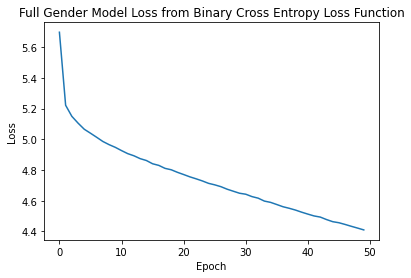

In [79]:
plt.plot(gender_model_history_4.history['loss'])
plt.title("Full Gender Model Loss from Binary Cross Entropy Loss Function")
plt.ylabel("Loss")
plt.xlabel("Epoch")

In [41]:
race_model4 = createRaceModel4()
race_model_balance4 = createRaceModel4()

In [49]:
full_race_race = tf.keras.utils.to_categorical(races_trn)
trn_race_balance = tf.keras.utils.to_categorical(raceTrnBalance)


array([[[[ 49,  53,  48],
         [ 48,  52,  47],
         [ 48,  52,  47],
         ...,
         [ 65,  73,  72],
         [ 66,  74,  73],
         [ 66,  74,  73]],

        [[ 48,  52,  47],
         [ 47,  51,  46],
         [ 47,  51,  46],
         ...,
         [ 65,  73,  72],
         [ 66,  74,  73],
         [ 66,  74,  73]],

        [[ 46,  50,  45],
         [ 46,  50,  45],
         [ 46,  50,  45],
         ...,
         [ 65,  73,  72],
         [ 66,  74,  73],
         [ 65,  73,  72]],

        ...,

        [[ 62,  75,  77],
         [ 62,  75,  77],
         [ 59,  74,  76],
         ...,
         [ 69,  82,  90],
         [ 68,  81,  89],
         [ 68,  81,  89]],

        [[ 62,  75,  77],
         [ 62,  75,  77],
         [ 59,  74,  76],
         ...,
         [ 70,  83,  91],
         [ 68,  81,  89],
         [ 68,  81,  89]],

        [[ 62,  75,  77],
         [ 62,  75,  77],
         [ 59,  74,  76],
         ...,
         [ 70,  83,  91],
        

In [43]:

race_model_history_4 = race_model4.fit(img_trn, full_race_race, epochs = 50)


Epoch 1/50
593/593 [==============================] - 27s 45ms/step - loss: 7.7071 - accuracy: 0.3108
Epoch 2/50
593/593 [==============================] - 27s 45ms/step - loss: 1.3390 - accuracy: 0.4883
Epoch 3/50
593/593 [==============================] - 27s 45ms/step - loss: 1.1761 - accuracy: 0.5676
Epoch 4/50
593/593 [==============================] - 27s 46ms/step - loss: 1.0832 - accuracy: 0.6160
Epoch 5/50
593/593 [==============================] - 27s 46ms/step - loss: 1.0066 - accuracy: 0.6487
Epoch 6/50
593/593 [==============================] - 27s 46ms/step - loss: 0.9773 - accuracy: 0.6570
Epoch 7/50
593/593 [==============================] - 27s 46ms/step - loss: 0.9518 - accuracy: 0.6614
Epoch 8/50
593/593 [==============================] - 27s 46ms/step - loss: 0.9135 - accuracy: 0.6778
Epoch 9/50
593/593 [==============================] - 27s 46ms/step - loss: 0.9222 - accuracy: 0.6834
Epoch 10/50
593/593 [==============================] - 27s 46ms/step - loss: 0.887

ValueError: ignored

In [51]:
y_pred4_race = race_model4.predict(img_tst)

In [58]:
i = y_pred4_race[1]
print(i)
checker = np.argmax(i)
print(checker)

[0.5470276  0.00867056 0.02180126 0.05041581 0.3720848 ]
0


In [60]:
predict_4_race = list()
for i in range(len(y_pred4_race)):
  largest_arg = np.argmax(y_pred4_race[i])
  predict_4_race.append(largest_arg)


In [69]:
a2 = accuracy_score(predict_4_race, races_tst)
print(a2*100)

74.94199535962876


In [71]:
print(classification_report(races_tst, predict_4_race))

              precision    recall  f1-score   support

           0       0.80      0.86      0.83      1987
           1       0.84      0.77      0.80       874
           2       0.89      0.70      0.79       728
           3       0.70      0.67      0.69       803
           4       0.27      0.34      0.30       349

    accuracy                           0.75      4741
   macro avg       0.70      0.67      0.68      4741
weighted avg       0.76      0.75      0.75      4741



Text(0.5, 0, 'Epoch')

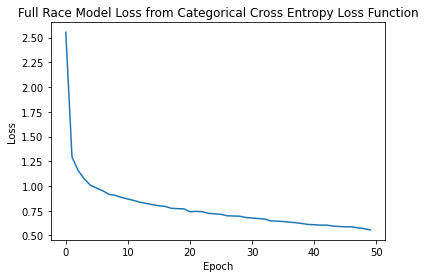

In [77]:
plt.plot(race_model_history_4.history['loss'])
plt.title("Full Race Model Loss from Categorical Cross Entropy Loss Function")
plt.ylabel("Loss")
plt.xlabel("Epoch")